In [ ]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
!pip install emcee
!pip install corner
import emcee
import seaborn as sns
import corner
import pymc3 as pm

# Implementación del modelo a los datos de .....

Los datos optenidos de https://loco.lab.asu.edu/edges/edges-data-release/, los cuales contienen la siguiente información Frequency [MHz], Weight, a: Tsky [K], b: Tres1 [K], c: Tres2 [K], d: Tmodel [K], e: T21 [K]

Donde la frecuencia y el peso son nuestros y a,b,c,d,e son nuestros parametros 

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata (4).csv


In [ ]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

**Griaficas**

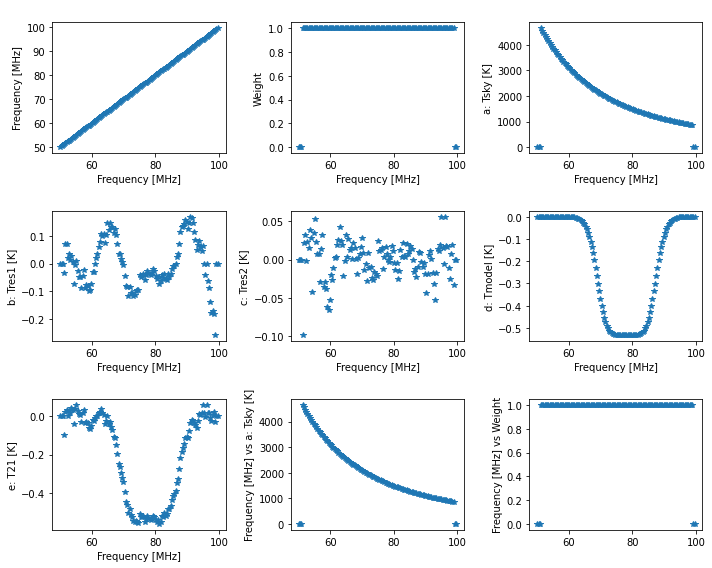

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10, 8))
for i, ax in enumerate(axes.flat, start=0):
    if i >6:
      ax.plot(Dat[:,0],Dat[:,9-i],'*',label=Names[9-i])
      ax.set_ylabel(Names[0] +' vs '+Names[9-i])
    else:
      ax.plot(Dat[:,0],Dat[:,i],'*',label=Names[i])
      ax.set_title("  ")
      ax.set_xlabel(Names[0])
      ax.set_ylabel(Names[i])
      #ax.legend()
fig.tight_layout()

plt.show()

## Modelo

Los datos para nuestro modelo son frecuenciua vs temperatura sky.
 El modelo consiste en obtener T_sky como la suma de $T_F$ (-.--------)y $T_{21}$ (Temperatura relacionada a la trancicion de 21 cm) $T_{sky}=T_F(\nu)+T_{21}(\nu)$
 
$T_F(\nu)$ esta modelada por la siguiente ecuación 

$$T_F(\nu)=a_o\left(\frac{\nu}{\nu_c}\right)^{-2.5}+a_1\left(\frac{\nu}{\nu_c}\right)^{-2.5}\log\left(\frac{\nu}{\nu_c}\right)+a_2\left(\frac{\nu}{\nu_c}\right)^{-2.5}\left[\log\left(\frac{\nu}{\nu_c}\right)\right]^2+a_3\left(\frac{\nu}{\nu_c}\right)^{-4.5}+a_4\left(\frac{\nu}{\nu_c}\right)^{-2.0}+$$

donde $T_F ( ν )$ es la temperatura de brillo de la emisión de primer plano, $ν$ es lafrecuencia, $ν_c$ es la frecuencia central de la banda observada y los coeficientes $a_n$ se ajustan a los datos. La función anterior es una aproximación lineal, centrada en $ν_c$ ,
$T_{21}$ tiene la siguiente expresón 
$$T_{21}=-A\left[\frac{1-e^{\tau e^B}}{1-e^{-\tau}}\right]$$

Donde 
$$B=\frac{4(v-\nu_o)^2}{w^2}\log\left(-{1\over \tau }\log\left({{1+e{\tau}}\over 2}\right)\right)$$


Text(0, 0.5, 'Temperatura del sky []')

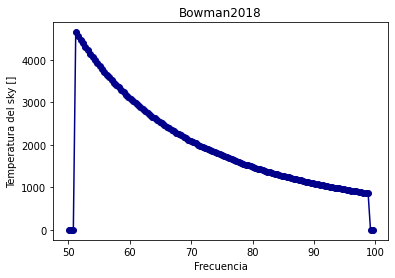

In [ ]:
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')

Ajuste lineal ejemplo

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'Temperatura del sky []')

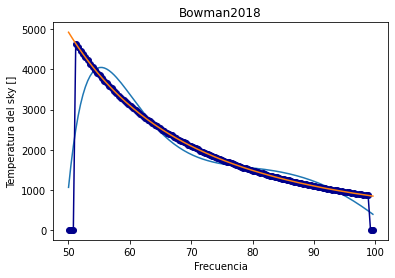

In [ ]:
def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=1
  Tf=a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
  B=4*(v-v0)**2/w**2*np.log10(1/tau*np.log10((1+np.e*tau)/2))
  T21=A*(1-np.e**(tau*np.e**B))/(1-np.e**-tau)
  return Tf+T21

popt, pcov = curve_fit(T_sky, Dat[:,0], Dat[:,2])
x_1,y_1=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0]
popt1, pcov1 = curve_fit(T_sky, x_1, y_1)

plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1))
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')

MLE ajuste

In [ ]:
"""Funciones 
"""
def f_(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=1
  Tf=a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
  B=4*(v-v0)**2/w**2*np.log10(1/tau*np.log10((1+np.e*tau)/2))
  T21=A*(1-np.e**(tau*np.e**B))/(1-np.e**-tau)
  return Tf+T21
####
def func(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=1
  Tf=a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
  B=4*(v-v0)**2/w**2*np.log10(1/tau*np.log10((1+np.e*tau)/2))
  T21=A*(1-np.e**(tau*np.e**B))/(1-np.e**-tau)
  return Tf+T21
####
def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau,log_f = theta
  sn2=sigma**2+f_(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2*np.exp(2*log_f)
  return -0.5*sum((y-f_(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2+ np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 
popt, pcov = curve_fit(func, Dat[:,0], Dat[:,1])

"""función prior"""
# theta es un arreglo con los valores de las contantes m,b,f
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau, log_f = theta
  if -5.0 < a0 < 0.5 and 0.0 < a1 < 10.0 and  0.0< a2 <10.0 and -10.0 < log_f < 1.0:
      return 0.0
  return -np.inf
# log probabilidad
def log_probability(theta, x, y, yerr):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # aun nos e porque se suman

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
#Parametros 

a0,a1,a2,a3,a4,A,v0,w,tau=popt1                      # intersección con el eje y
f=Dat[:,0].std()
N=len(Dat)

#Variables
 # ""   ""   ""    ""    ""     ""   que tienen una distribución normal 
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0]
yerr=3.0+0*x
x0=np.linspace(min(x),max(x),len(x))


In [ ]:
nll=lambda *args: -log_likelihood(*args) # Construccion lamda 

#Condiciones iniciales

In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau,np.log(f)])+ 0.1 * np.random.randn(10)

#Solución
Sol=minimize(nll,In,args=(x, y, yerr))
# Extrayendo los valores de los parametros arojados por MlE
popt = Sol.x
popt=popt[0:9]
print('los valores de las constantes a,b,c, log(f)  son :',popt)




los valores de las constantes a,b,c, log(f)  son : [ 7.60772295e+06  1.00220270e+08 -4.49891403e+07  9.80343573e-01
  5.53212170e+06  9.45717996e-01  9.43410817e-01  1.03230101e+00
  1.25926803e+00]


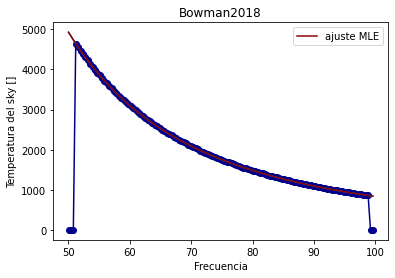

In [ ]:

plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt),color='darkred',label='ajuste MLE')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.legend()

In [ ]:
pos = Sol.x + 1e-2 * np.random.randn(52, 10)  # posterior ,randn genera 3 arreglos de 32 n umeros aleatorios
nwalkers, ndim = pos.shape # 32 caminos, 10 dimensión 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:00<00:00, 1159.40it/s]


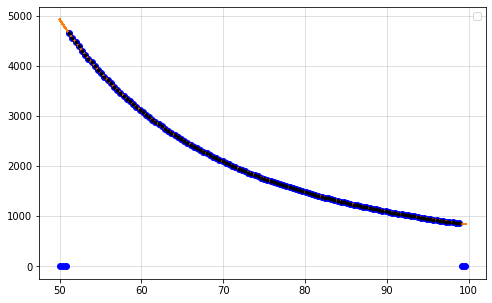

In [ ]:
params=sampler.get_chain(discard=10, thin=25, flat=True)#parametros


plt.figure(figsize=(8,5))
plt.plot(Dat[:,0],Dat[:,2],'bo')
for i in range(len(params)):
  ms=params[0]
  ms=ms[0:9]
  plt.plot(Dat[:,0],T_sky(Dat[:,0],*ms), "C1", alpha=0.1)
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0) #Grafica la muetras con su respectivo error
#plt.xlim(min(x),max(x))
#plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)

##Grafico de esquina:

In [ ]:
#corner.corner(params,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
#plt.show()

#Modelo Pymcee

In [ ]:
d1=Dat[:,2] # Valores de la temperatura
d2=Dat[:,0] # Valores de frecuencia
v=(d1-d1.mean())/d1.std()


with pm.Model() as pred_model:
    a0=pm.Normal('a0',mu=0,sd=10)
    a1=pm.Normal('a1',mu=0,sd=10)
    a2=pm.Normal('a2',mu=0,sd=10)
    a3=pm.Normal('a3',mu=0,sd=10)
    a4=pm.Normal('a4',mu=0,sd=10)
    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
    A=pm.Normal('A',mu=0,sd=10)
    v0=pm.Normal('v0',mu=0,sd=10)
    w=pm.Normal('w',mu=0,sd=10)
    tau=pm.Normal('tau',mu=0,sd=10)
    T21=(A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*np.log10(1/tau*np.log10((1+np.e*tau)/2)))))/(1-np.e**-tau))
    mu=pm.Deterministic('mu',TF+T21)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    #Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
    trace_pred=pm.sample(1000,tune=1000)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2]
trace_array_3=np.array([trace_pred[i] for i in vnames]).T

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
INFO:pymc3:NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
100%|██████████| 2000/2000 [00:04<00:00, 477.02it/s]


In [ ]:
trace_pred.varnames


['a0',
 'a1',
 'a2',
 'a3',
 'a4',
 'A',
 'v0',
 'w',
 'tau',
 'sigma_interval__',
 'mu',
 'sigma']

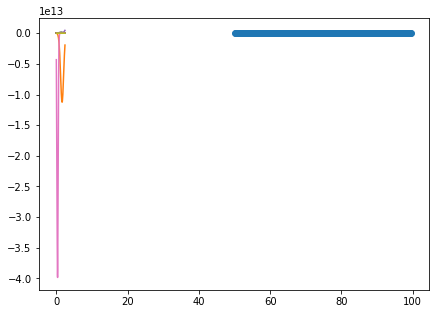

In [ ]:
plt.figure(figsize=(7,5))
for i in range(len(trace_array_3)):
  par=trace_array_3[i]
  par=par[0:9]
  plt.plot(v,T_sky(v,*par))
plt.plot(Dat[:,0],Dat[:,2],'o')

NameError: ignored

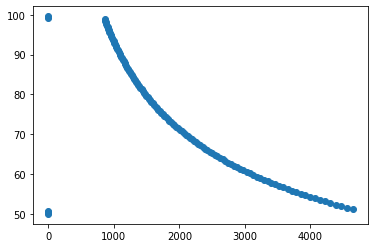

In [ ]:
x=np.linspace(v.min(),v.max(),100)
mean_pars=trace_array_3.mean(axis=0) # parametros del modelo
plt.scatter(d1,d2)

for vnames in trace_array_3[np.random.randint(len(trace_array_3), size=20)]:
    plt.plot(x*d1.std()+d1.mean(),a+b1*x+b2*x**2+b3*x**3,color="k",alpha=0.5)
plt.plot(x*d1.std()+d1.mean(),mean_pars[0]+(x)*mean_pars[1]+(x**2)*mean_pars[2]+(x**3)*mean_pars[3],c='r')
plt.show()

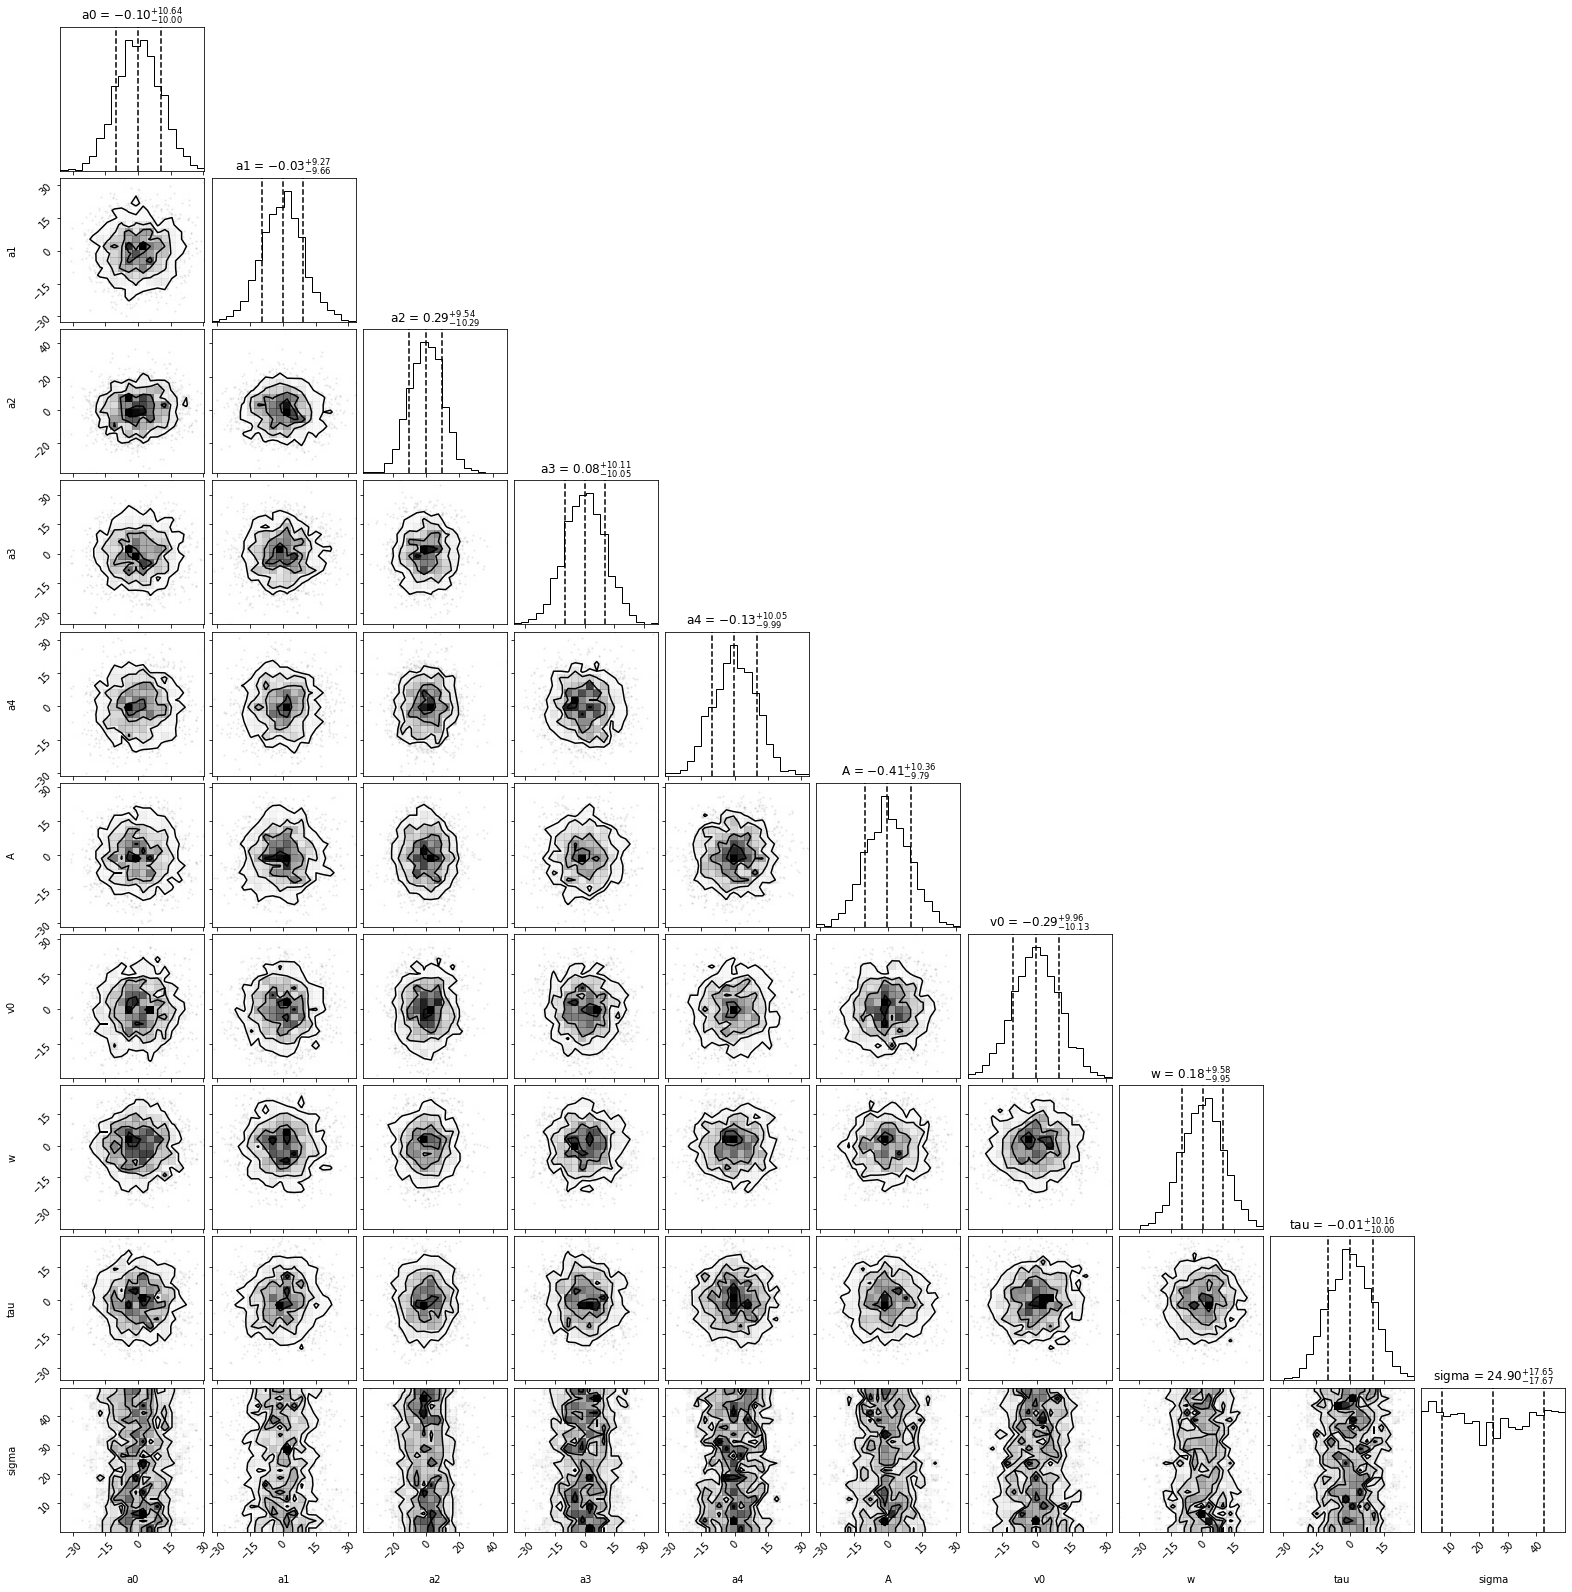

In [ ]:
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2]
trace_array_2=np.array([trace_pred[i] for i in vnames]).T
corner.corner(trace_array_2,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

In [ ]:
len(trace_array_2),len(params)